# Present Wrapping Problem

The PWP can be seen as a specialization of the more general rectangle packing problem, in which we have a set of rectangles (our presents) of given dimensions that have to fit into a pre-determined square (the wrapping paper) of a given size. The great thing about PWP is that we kwow the items will perfectly fit into the given container, without any kind of wasted space.

We decided to use a list of bottom left corners (with the same index set as the list of presents shapes) as the solution representation. So, the main constraint we have dealt with are the following ones:
* Rectangles cannot overlap
* Rectangles should be completely contained inside the wrapping paper
* No wasted paper
* Rectangles cannot be rotated (unless specified)

In [2]:
%load_ext autoreload
%load_ext iminizinc
%matplotlib inline
%autoreload 2

import string
import random
from time import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from z3 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The iminizinc extension is already loaded. To reload it, use:
  %reload_ext iminizinc


## Functions

This section contains different utility functions, needed to deal with instances input/output, results handling (solutions graphical representation and running time plots), ...

In [3]:
def rand_str(size=10, chars=string.ascii_uppercase + string.digits):
    '''
    Returns a string of the given length with randomly chosen characters
    '''
    return ''.join(random.choice(chars) for _ in range(size))

In [4]:
def read_input(path):
    '''
    Read the given input instance, which should have the following format:

    W H
    N
    P1X P1Y
    ...
    PNX PNY

    Here, PIJ means present I, coordinate J, while W and H are the paper's dimensions
    '''
    file = open(path, "r").readlines()
    w_paper , h_paper = tuple(map(int, file[0].rstrip("\n").split(" ")))
    n = int(file[1].rstrip("\n"))
    presents = []
    for i in range(2, n + 2):
        presents.append(list(map(int, file[i].rstrip("\n").split(" "))))
    return w_paper, h_paper, n, presents

In [28]:
def show_solutions(w_paper, h_paper, n, presents, solutions, model):
    '''
    Show each and every solution as 2D plots
    '''
    if not isinstance(solutions,list):
        solutions = [solutions]

    colors = np.random.rand(n, 3)
    for solution in solutions:
        show_solution(w_paper, h_paper, n, presents, solution, model, colors)

def show_solution(w_paper, h_paper, n, presents, solution, model, colors=None):
    '''
    Show the given solution as a 2D plot. 
    The solution should be a list of bottom left corners, 
    contained in the given w_paper and h_paper margins
    '''
    assert(isinstance(w_paper, int))
    assert(isinstance(h_paper, int))
    assert(isinstance(presents, list))
    assert(isinstance(n, int) and n == len(presents))
    assert(isinstance(solution, dict))
    assert('bl_corners' in solutions)
    assert(len(presents) == len(solution['bl_corners']))

    bl_corners = solution['bl_corners']
    if 'kind' in solution:
        for i in range(n):
            if solution['kind'][i] % 2 == 0:
                presents[i][1], presents[i][0] = presents[i][0], presents[i][1]

    if colors is None:
        colors = np.random.rand(n, 3)
    fig, ax = plt.subplots()
    for i in range(n):
        ax.add_patch(patches.Rectangle(
            bl_corners[i],
            presents[i][0],
            presents[i][1],
            facecolor=colors[i]
        ))
    ax.set_xlim(0, w_paper)
    ax.set_ylim(0, h_paper)
    print(f"Solution: {bl_corners}")
    plt.show()
    output(w_paper, h_paper, n, presents, bl_corners, model)

In [6]:
def show_running_times(instances, times):
    '''
    Show instance size versus running time plot
    '''
    fig = plt.figure(figsize=(12, 8), dpi= 100, facecolor='w', edgecolor='k')
    plt.xlabel("Instance")
    plt.ylabel("Total running time")
    plt.plot(instances, times, marker='o', linestyle='dashed', linewidth=2, markersize=12)
    plt.show()

In [7]:
def order_presents(presents, method='height', reverse=False):
    '''
    Order presents, increasing or decreasing, 
    by the given method (area, height, width)
    '''
    to_sort = (
        [e[0] * e[1] for e in presents] if method == 'area'
        else [e[1] for e in presents] if method == 'height'
        else [e[0] for e in presents] if method == 'width'
        else None
    )
    sorted_indices = sorted(range(len(to_sort)), key=lambda k: to_sort[k], reverse=reverse)
    presents = [presents[i] for i in sorted_indices]
    return presents, sorted_indices

In [24]:
def output(w_paper, h_paper, n, presents, bl_corners, model):
    '''
    Write the given solution to an output file, in a specific output folder,
    with the following format:
    
    W H
    N
    P1X P1Y  C1X C1Y
    ...
    PNX PNY  CNX CNY

    Here, PIJ means present I, coordinate J; 
    CIJ means coordinate J of the bottom left corner of present I; 
    while W and H are the paper's dimensions
    '''
    out_file = open(f"out/{model}/{w_paper}x{h_paper}-out.txt", "w+")
    print(f"{w_paper} {h_paper}", file=out_file)
    print(f"{n}", file=out_file)
    for present, position in zip(presents, bl_corners):
        present_x, present_y = present
        position_x, position_y = position
        print(f"{present_x} {present_y}{2 * ' '}{position_x} {position_y}", file=out_file)
    out_file.close()

## CP

In this section, we reported various CP models, in which we tried different approaches, evolving from one another on the basis of references and own ideas. Some of them tend to be faster in a specific subset of instances, w.r.t. the others. In the final model, we tried to put together the different key-points of each model.

CP models are implemented with the MiniZinc language and models execution is managed by the official MiniZinc Jupyter extension, called iMiniZinc.

### Input

The following subsection is dedicated to input handling. In particular, if we want to test a single instance, we can set the `instance` variable and execute the code below to visualize one associated solution. If instead we want to test every single instance, we can just set the `instance` variable to the special value `None` and still execute the code below to both visualize every computed solution and analyze running times for every instance.

In [87]:
instance = 23
min_instance, max_instance = 8, 40

Paper dimensions: 8x8
Presents dimensions: [[5, 5], [3, 5], [5, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatIntVars=20
mzn-stat: flatIntConstraints=7
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.115327
mzn-stat-end
mzn-stat: initTime=0.005
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=52
mzn-stat: propagators=0
mzn-stat: propagations=5
mzn-stat: nodes=1
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=0
mzn-stat-end
Solution: [[0, 0], [5, 0], [0, 5], [5, 5]]


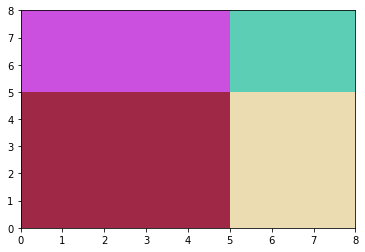


Paper dimensions: 9x9
Presents dimensions: [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=142
mzn-stat: flatIntVars=80
mzn-stat: flatBoolConstraints=67
mzn-stat: flatIntConstraints=197
mzn-stat: evaluatedReifiedConstraints=17
mzn-stat: evaluatedHalfReifiedConstraints=142
mzn-stat: eliminatedImplications=30
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.125285
mzn-stat-end
mzn-stat: initTime=0.01
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=225
mzn-stat: propagators=252
mzn-stat: propagations=545
mzn-stat: nodes=3
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=2
mzn-stat-end
Solution: [[0, 0], [3, 0], [6, 0], [6, 5], [3, 6]]


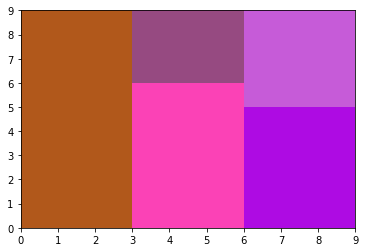


Paper dimensions: 10x10
Presents dimensions: [[4, 6], [3, 7], [3, 6], [4, 4], [3, 4], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=109
mzn-stat: flatIntVars=64
mzn-stat: flatBoolConstraints=42
mzn-stat: flatIntConstraints=148
mzn-stat: evaluatedReifiedConstraints=10
mzn-stat: evaluatedHalfReifiedConstraints=103
mzn-stat: eliminatedImplications=12
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.121918
mzn-stat-end
mzn-stat: initTime=0.01
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=189
mzn-stat: propagators=146
mzn-stat: propagations=361
mzn-stat: nodes=2
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=1
mzn-stat-end
Solution: [[0, 0], [4, 0], [7, 0], [0, 6], [7, 6], [4, 7]]


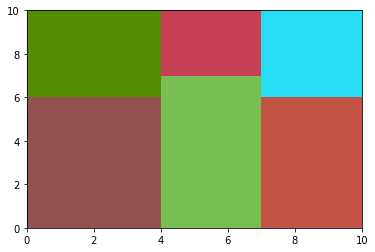


Paper dimensions: 11x11
Presents dimensions: [[8, 4], [5, 4], [3, 6], [3, 5], [5, 3], [3, 4], [3, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=91
mzn-stat: flatIntVars=63
mzn-stat: flatBoolConstraints=21
mzn-stat: flatIntConstraints=147
mzn-stat: evaluatedReifiedConstraints=7
mzn-stat: evaluatedHalfReifiedConstraints=84
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.120151
mzn-stat-end
mzn-stat: initTime=0.009
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=154
mzn-stat: propagators=164
mzn-stat: propagations=1065
mzn-stat: nodes=26
mzn-stat: failures=9
mzn-stat: restarts=0
mzn-stat: peakDepth=10
mzn-stat-end
Solution: [[0, 0], [0, 4], [8, 0], [8, 6], [0, 8], [5, 4], [5, 8]]


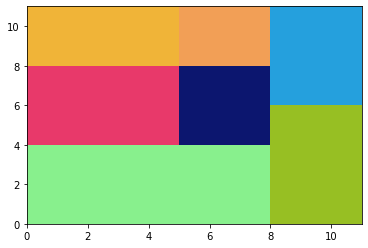


Paper dimensions: 12x12
Presents dimensions: [[3, 9], [3, 8], [3, 7], [3, 6], [6, 3], [3, 5], [3, 4], [3, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=120
mzn-stat: flatIntVars=72
mzn-stat: flatBoolConstraints=28
mzn-stat: flatIntConstraints=183
mzn-stat: evaluatedReifiedConstraints=8
mzn-stat: evaluatedHalfReifiedConstraints=112
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.123278
mzn-stat-end
mzn-stat: initTime=0.01
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=192
mzn-stat: propagators=193
mzn-stat: propagations=2119
mzn-stat: nodes=34
mzn-stat: failures=13
mzn-stat: restarts=0
mzn-stat: peakDepth=13
mzn-stat-end
Solution: [[0, 0], [6, 0], [9, 0], [3, 0], [0, 9], [9, 7], [6, 8], [3, 6]]


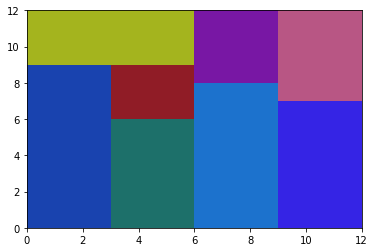


Paper dimensions: 13x13
Presents dimensions: [[7, 6], [3, 8], [3, 7], [3, 6], [4, 4], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=153
mzn-stat: flatIntVars=81
mzn-stat: flatBoolConstraints=36
mzn-stat: flatIntConstraints=223
mzn-stat: evaluatedReifiedConstraints=9
mzn-stat: evaluatedHalfReifiedConstraints=144
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.141067
mzn-stat-end
mzn-stat: initTime=0.011
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=234
mzn-stat: propagators=251
mzn-stat: propagations=3449
mzn-stat: nodes=102
mzn-stat: failures=46
mzn-stat: restarts=0
mzn-stat: peakDepth=13
mzn-stat-end
Solution: [[0, 0], [7, 0], [10, 0], [10, 7], [0, 6], [7, 8], [4, 6], [0, 10], [4, 10]]


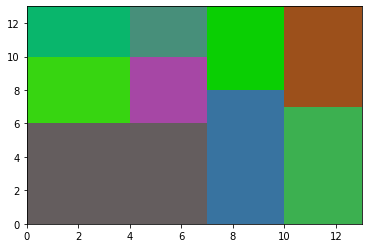


Paper dimensions: 14x14
Presents dimensions: [[5, 10], [3, 9], [3, 8], [3, 7], [5, 4], [3, 6], [3, 5], [3, 4], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=310
mzn-stat: flatIntVars=146
mzn-stat: flatBoolConstraints=140
mzn-stat: flatIntConstraints=408
mzn-stat: evaluatedReifiedConstraints=25
mzn-stat: evaluatedHalfReifiedConstraints=327
mzn-stat: eliminatedImplications=63
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.159283
mzn-stat-end
mzn-stat: initTime=0.015
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=472
mzn-stat: propagators=472
mzn-stat: propagations=1206
mzn-stat: nodes=3
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=2
mzn-stat-end
Solution: [[0, 0], [5, 0], [8, 0], [11, 0], [0, 10], [8, 8], [5, 9], [11, 7], [11, 11]]


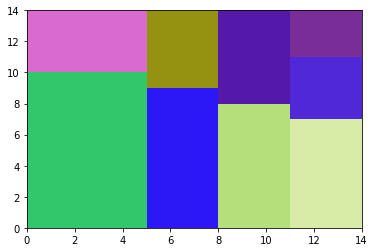


Paper dimensions: 15x15
Presents dimensions: [[3, 15], [3, 12], [3, 9], [3, 8], [3, 7], [3, 6], [6, 3], [3, 5], [3, 4], [3, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=190
mzn-stat: flatIntVars=87
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=264
mzn-stat: evaluatedReifiedConstraints=10
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.125096
mzn-stat-end
mzn-stat: initTime=0.013
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=281
mzn-stat: propagators=275
mzn-stat: propagations=2681
mzn-stat: nodes=77
mzn-stat: failures=33
mzn-stat: restarts=0
mzn-stat: peakDepth=13
mzn-stat-end
Solution: [[0, 0], [3, 0], [6, 0], [9, 0], [12, 0], [6, 9], [9, 12], [12, 7], [9, 8], [3, 12]]


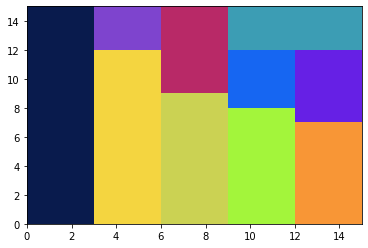


Paper dimensions: 16x16
Presents dimensions: [[7, 9], [3, 12], [3, 10], [4, 7], [3, 8], [3, 7], [3, 6], [3, 5], [3, 4], [3, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=190
mzn-stat: flatIntVars=90
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=267
mzn-stat: evaluatedReifiedConstraints=10
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.124261
mzn-stat-end
mzn-stat: initTime=0.013
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=280
mzn-stat: propagators=284
mzn-stat: propagations=3004
mzn-stat: nodes=88
mzn-stat: failures=39
mzn-stat: restarts=0
mzn-stat: peakDepth=15
mzn-stat-end
Solution: [[0, 0], [7, 0], [10, 0], [0, 9], [13, 0], [4, 9], [10, 10], [13, 8], [7, 12], [13, 13]]


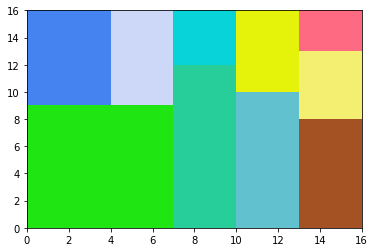


Paper dimensions: 17x17
Presents dimensions: [[4, 14], [7, 6], [4, 8], [3, 9], [3, 8], [3, 7], [7, 3], [3, 6], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=276
mzn-stat: flatIntVars=108
mzn-stat: flatBoolConstraints=66
mzn-stat: flatIntConstraints=367
mzn-stat: evaluatedReifiedConstraints=12
mzn-stat: evaluatedHalfReifiedConstraints=264
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.127469
mzn-stat-end
mzn-stat: initTime=0.015
mzn-stat: solveTime=0.012
mzn-stat: solutions=1
mzn-stat: variables=384
mzn-stat: propagators=417
mzn-stat: propagations=61118
mzn-stat: nodes=1370
mzn-stat: failures=678
mzn-stat: restarts=0
mzn-stat: peakDepth=26
mzn-stat-end
Solution: [[0, 0], [4, 0], [7, 6], [11, 0], [14, 0], [4, 6], [7, 14], [14, 8], [11, 9], [4, 13], [0, 14], [14, 14]]


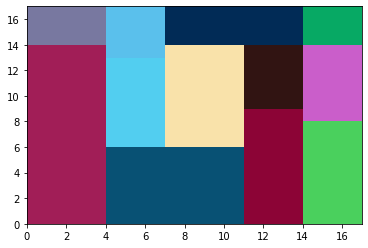


Paper dimensions: 18x18
Presents dimensions: [[3, 11], [3, 10], [5, 6], [5, 5], [3, 8], [4, 6], [3, 7], [4, 5], [5, 4], [3, 6], [4, 4], [3, 5], [5, 3], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=575
mzn-stat: flatIntVars=206
mzn-stat: flatBoolConstraints=224
mzn-stat: flatIntConstraints=703
mzn-stat: evaluatedReifiedConstraints=29
mzn-stat: evaluatedHalfReifiedConstraints=606
mzn-stat: eliminatedImplications=84
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.162244
mzn-stat-end
mzn-stat: initTime=0.023
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=845
mzn-stat: propagators=706
mzn-stat: propagations=2674
mzn-stat: nodes=8
mzn-stat: failures=2
mzn-stat: restarts=0
mzn-stat: peakDepth=5
mzn-stat-end
Solution: [[9, 0], [12, 0], [0, 0], [0, 6], [15, 0], [5, 0], [9, 11], [5, 6], [0, 11], [15, 8], [5, 11], [12, 10], [0, 15], [15, 14], [5, 15], [12, 15]]


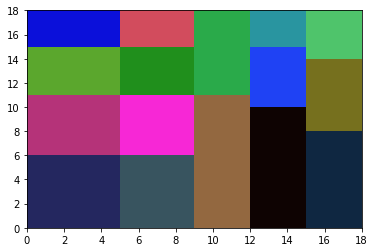


Paper dimensions: 19x19
Presents dimensions: [[3, 19], [3, 13], [3, 11], [4, 8], [3, 10], [3, 9], [3, 8], [4, 6], [3, 7], [4, 5], [3, 6], [3, 5], [3, 4], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=893
mzn-stat: flatIntVars=401
mzn-stat: flatBoolConstraints=468
mzn-stat: flatIntConstraints=1198
mzn-stat: evaluatedReifiedConstraints=61
mzn-stat: evaluatedHalfReifiedConstraints=1056
mzn-stat: eliminatedImplications=275
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.208646
mzn-stat-end
mzn-stat: initTime=0.034
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=1321
mzn-stat: propagators=1502
mzn-stat: propagations=6235
mzn-stat: nodes=10
mzn-stat: failures=2
mzn-stat: restarts=0
mzn-stat: peakDepth=7
mzn-stat-end
Solution: [[4, 0], [7, 0], [10, 0], [0, 0], [13, 0], [16, 0], [10, 11], [0, 8], [16, 9], [0, 14], [7, 13], [13, 10], [13, 15], [16, 16]]


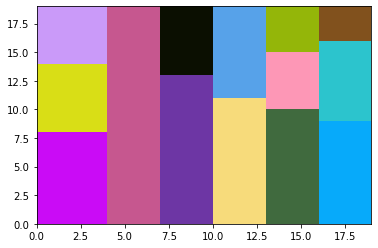


Paper dimensions: 20x20
Presents dimensions: [[4, 17], [3, 17], [4, 11], [4, 9], [3, 11], [3, 10], [3, 9], [3, 8], [3, 7], [3, 6], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=800
mzn-stat: flatIntVars=338
mzn-stat: flatBoolConstraints=379
mzn-stat: flatIntConstraints=1049
mzn-stat: evaluatedReifiedConstraints=56
mzn-stat: evaluatedHalfReifiedConstraints=888
mzn-stat: eliminatedImplications=192
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.191203
mzn-stat-end
mzn-stat: initTime=0.03
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=1138
mzn-stat: propagators=1380
mzn-stat: propagations=3566
mzn-stat: nodes=5
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=4
mzn-stat-end
Solution: [[0, 0], [8, 0], [4, 0], [4, 11], [11, 0], [14, 0], [11, 11], [17, 0], [17, 8], [14, 10], [17, 15], [14, 16], [0, 17], [8, 17]]


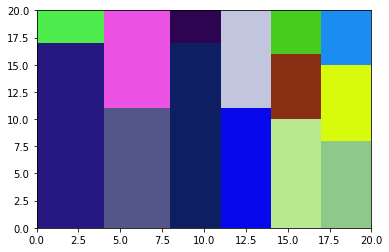


Paper dimensions: 21x21
Presents dimensions: [[5, 15], [3, 18], [4, 11], [3, 14], [3, 10], [5, 6], [3, 9], [3, 8], [4, 6], [3, 7], [3, 6], [4, 4], [3, 5], [3, 4], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=763
mzn-stat: flatIntVars=309
mzn-stat: flatBoolConstraints=355
mzn-stat: flatIntConstraints=983
mzn-stat: evaluatedReifiedConstraints=46
mzn-stat: evaluatedHalfReifiedConstraints=857
mzn-stat: eliminatedImplications=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.177406
mzn-stat-end
mzn-stat: initTime=0.03
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=1112
mzn-stat: propagators=1119
mzn-stat: propagations=3070
mzn-stat: nodes=4
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=3
mzn-stat-end
Solution: [[0, 0], [9, 0], [5, 0], [12, 0], [15, 0], [0, 15], [18, 0], [18, 9], [5, 11], [12, 14], [15, 10], [5, 17], [15, 16], [18, 17], [9, 18]]


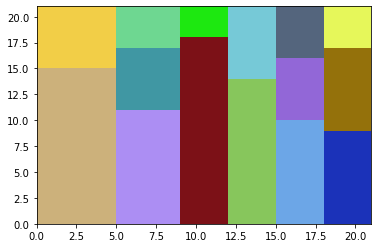


Paper dimensions: 22x22
Presents dimensions: [[4, 19], [3, 22], [3, 14], [3, 13], [3, 12], [3, 11], [3, 10], [3, 9], [3, 8], [6, 4], [3, 7], [3, 6], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=496
mzn-stat: flatIntVars=141
mzn-stat: flatBoolConstraints=120
mzn-stat: flatIntConstraints=612
mzn-stat: evaluatedReifiedConstraints=16
mzn-stat: evaluatedHalfReifiedConstraints=480
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.148835
mzn-stat-end
mzn-stat: initTime=0.022
mzn-stat: solveTime=0.01
mzn-stat: solutions=1
mzn-stat: variables=642
mzn-stat: propagators=654
mzn-stat: propagations=29312
mzn-stat: nodes=833
mzn-stat: failures=408
mzn-stat: restarts=0
mzn-stat: peakDepth=29
mzn-stat-end
Solution: [[0, 0], [4, 0], [7, 0], [10, 0], [13, 0], [16, 0], [19, 0], [19, 10], [7, 14], [10, 18], [16, 11], [13, 12], [10, 13], [16, 18], [0, 19], [19, 19]]


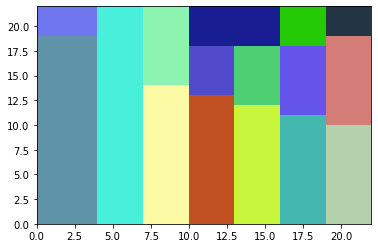


Paper dimensions: 23x23
Presents dimensions: [[3, 20], [4, 12], [4, 11], [3, 14], [4, 10], [3, 12], [3, 11], [3, 10], [3, 9], [3, 8], [4, 6], [3, 7], [3, 6], [6, 3], [4, 4], [3, 5], [3, 4], [4, 3], [3, 3]]
Error in MiniZinc:
Column stacking: false
%%%mzn-stat: nSolutions=0


Paper dimensions: 24x24
Presents dimensions: [[5, 16], [3, 24], [3, 18], [4, 12], [3, 14], [5, 8], [3, 12], [3, 10], [3, 9], [3, 8], [3, 7], [4, 5], [3, 6], [4, 4], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1168
mzn-stat: flatIntVars=482
mzn-stat: flatBoolConstraints=583
mzn-stat: flatIntConstraints=1534
mzn-stat: evaluatedReifiedConstraints=67
mzn-stat: evaluatedHalfReifiedConstraints=1375
mzn-stat: eliminatedImplications=330
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.215375
mzn-stat-end
mzn-stat: initTime=0.041
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=1701
m

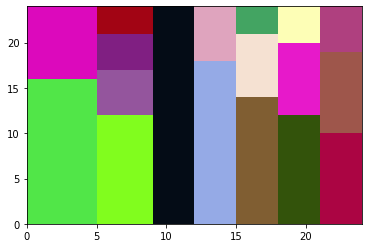


Paper dimensions: 25x25
Presents dimensions: [[3, 25], [3, 19], [3, 18], [4, 13], [3, 17], [3, 14], [3, 13], [3, 11], [3, 10], [4, 7], [3, 9], [3, 8], [3, 7], [4, 5], [3, 6], [6, 3], [3, 5], [3, 4], [3, 3]]
Column stacking: false
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=703
mzn-stat: flatIntVars=168
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=840
mzn-stat: evaluatedReifiedConstraints=19
mzn-stat: evaluatedHalfReifiedConstraints=684
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.159429
mzn-stat-end
mzn-stat: initTime=0.028
mzn-stat: solveTime=0.002
mzn-stat: solutions=1
mzn-stat: variables=876
mzn-stat: propagators=919
mzn-stat: propagations=8885
mzn-stat: nodes=185
mzn-stat: failures=82
mzn-stat: restarts=0
mzn-stat: peakDepth=31
mzn-stat-end
Solution: [[0, 0], [3, 0], [6, 0], [9, 0], [13, 0], [16, 0], [19, 0], [22, 0], [22, 11], [9, 13], [19, 13], [16, 14], [6, 18], [9, 20], [3, 19], [13, 22],

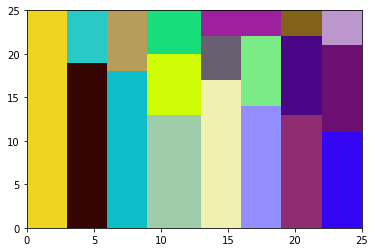


Paper dimensions: 26x26
Presents dimensions: [[3, 19], [4, 14], [3, 17], [3, 16], [3, 15], [4, 11], [3, 14], [3, 12], [3, 11], [4, 8], [3, 10], [4, 7], [3, 9], [3, 8], [3, 7], [4, 5], [3, 6], [4, 4], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=2124
mzn-stat: flatIntVars=900
mzn-stat: flatBoolConstraints=1111
mzn-stat: flatIntConstraints=2853
mzn-stat: evaluatedReifiedConstraints=118
mzn-stat: evaluatedHalfReifiedConstraints=2574
mzn-stat: eliminatedImplications=672
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.277493
mzn-stat-end
mzn-stat: initTime=0.068
mzn-stat: solveTime=0.024
mzn-stat: solutions=1
mzn-stat: variables=3024
mzn-stat: propagators=3904
mzn-stat: propagations=64339
mzn-stat: nodes=825
mzn-stat: failures=407
mzn-stat: restarts=0
mzn-stat: peakDepth=45
mzn-stat-end
Solution: [[8, 0], [0, 0], [11, 0], [14, 0], [17, 0], [4, 0], [20, 0], [23, 0], [23,

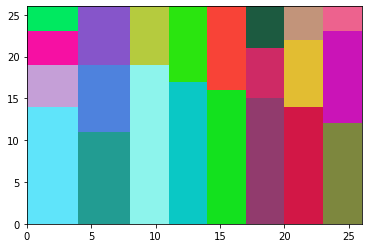


Paper dimensions: 27x27
Presents dimensions: [[4, 20], [4, 19], [3, 21], [3, 20], [3, 19], [4, 14], [3, 12], [3, 11], [4, 8], [3, 10], [4, 7], [3, 9], [3, 8], [4, 6], [3, 7], [3, 6], [4, 4], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1766
mzn-stat: flatIntVars=692
mzn-stat: flatBoolConstraints=862
mzn-stat: flatIntConstraints=2305
mzn-stat: evaluatedReifiedConstraints=102
mzn-stat: evaluatedHalfReifiedConstraints=2049
mzn-stat: eliminatedImplications=474
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.261808
mzn-stat-end
mzn-stat: initTime=0.056
mzn-stat: solveTime=0.008
mzn-stat: solutions=1
mzn-stat: variables=2458
mzn-stat: propagators=3081
mzn-stat: propagations=36087
mzn-stat: nodes=530
mzn-stat: failures=260
mzn-stat: restarts=0
mzn-stat: peakDepth=32
mzn-stat-end
Solution: [[0, 0], [4, 0], [12, 0], [15, 0], [18, 0], [8, 0], [21, 0], [24, 0], [4, 19], [21, 

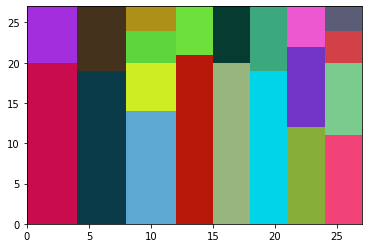


Paper dimensions: 28x28
Presents dimensions: [[4, 23], [3, 23], [5, 13], [3, 21], [4, 13], [3, 17], [3, 16], [5, 9], [3, 11], [4, 8], [3, 10], [5, 6], [3, 9], [3, 8], [3, 7], [4, 5], [3, 6], [4, 4], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1724
mzn-stat: flatIntVars=631
mzn-stat: flatBoolConstraints=802
mzn-stat: flatIntConstraints=2208
mzn-stat: evaluatedReifiedConstraints=89
mzn-stat: evaluatedHalfReifiedConstraints=1978
mzn-stat: eliminatedImplications=420
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.236751
mzn-stat-end
mzn-stat: initTime=0.056
mzn-stat: solveTime=0.002
mzn-stat: solutions=1
mzn-stat: variables=2379
mzn-stat: propagators=2714
mzn-stat: propagations=16742
mzn-stat: nodes=90
mzn-stat: failures=41
mzn-stat: restarts=0
mzn-stat: peakDepth=14
mzn-stat-end
Solution: [[5, 0], [13, 0], [0, 0], [16, 0], [9, 0], [19, 0], [22, 0], [0, 13], [19, 17],

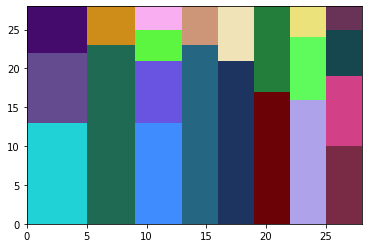


Paper dimensions: 29x29
Presents dimensions: [[5, 17], [4, 20], [4, 18], [3, 20], [4, 15], [3, 18], [3, 15], [5, 8], [4, 9], [3, 11], [3, 10], [4, 7], [3, 9], [3, 8], [4, 6], [3, 7], [4, 5], [5, 4], [3, 6], [4, 4], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1848
mzn-stat: flatIntVars=603
mzn-stat: flatBoolConstraints=795
mzn-stat: flatIntConstraints=2300
mzn-stat: evaluatedReifiedConstraints=89
mzn-stat: evaluatedHalfReifiedConstraints=2056
mzn-stat: eliminatedImplications=372
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.248103
mzn-stat-end
mzn-stat: initTime=0.06
mzn-stat: solveTime=0.031
mzn-stat: solutions=1
mzn-stat: variables=2475
mzn-stat: propagators=2808
mzn-stat: propagations=75095
mzn-stat: nodes=1240
mzn-stat: failures=615
mzn-stat: restarts=0
mzn-stat: peakDepth=43
mzn-stat-end
Solution: [[0, 0], [5, 0], [9, 0], [17, 0], [13, 0], [20, 0], [23, 0], 

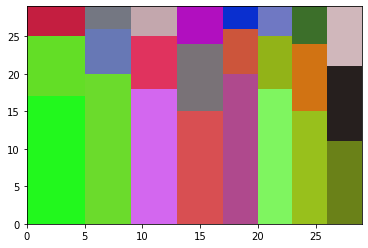


Paper dimensions: 30x30
Presents dimensions: [[11, 30], [3, 25], [3, 19], [3, 16], [3, 14], [3, 13], [4, 9], [3, 11], [4, 8], [3, 10], [3, 9], [3, 8], [4, 6], [3, 7], [3, 6], [4, 4], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1510
mzn-stat: flatIntVars=630
mzn-stat: flatBoolConstraints=770
mzn-stat: flatIntConstraints=2005
mzn-stat: evaluatedReifiedConstraints=79
mzn-stat: evaluatedHalfReifiedConstraints=1816
mzn-stat: eliminatedImplications=455
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.259692
mzn-stat-end
mzn-stat: initTime=0.056
mzn-stat: solveTime=0.006
mzn-stat: solutions=1
mzn-stat: variables=2188
mzn-stat: propagators=2431
mzn-stat: propagations=20254
mzn-stat: nodes=289
mzn-stat: failures=141
mzn-stat: restarts=0
mzn-stat: peakDepth=19
mzn-stat-end
Solution: [[0, 0], [15, 0], [18, 0], [21, 0], [24, 0], [27, 0], [11, 0], [27, 13], [11, 9], [21, 16], [

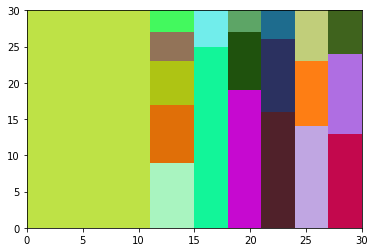


Paper dimensions: 31x31
Presents dimensions: [[12, 31], [3, 31], [3, 22], [4, 13], [3, 14], [3, 13], [3, 12], [3, 11], [4, 8], [3, 10], [4, 7], [3, 9], [3, 8], [3, 7], [3, 6], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1439
mzn-stat: flatIntVars=622
mzn-stat: flatBoolConstraints=751
mzn-stat: flatIntConstraints=1934
mzn-stat: evaluatedReifiedConstraints=79
mzn-stat: evaluatedHalfReifiedConstraints=1749
mzn-stat: eliminatedImplications=455
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.25061
mzn-stat-end
mzn-stat: initTime=0.05
mzn-stat: solveTime=0.008
mzn-stat: solutions=1
mzn-stat: variables=2104
mzn-stat: propagators=2380
mzn-stat: propagations=32679
mzn-stat: nodes=483
mzn-stat: failures=237
mzn-stat: restarts=0
mzn-stat: peakDepth=35
mzn-stat-end
Solution: [[0, 0], [16, 0], [19, 0], [12, 0], [22, 0], [25, 0], [28, 0], [28, 12], [12, 13], [25, 13], [12, 21],

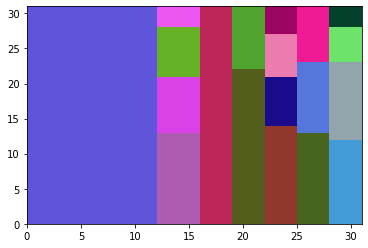


Paper dimensions: 32x32
Presents dimensions: [[3, 27], [3, 25], [3, 24], [4, 18], [3, 23], [3, 22], [3, 18], [3, 15], [4, 11], [3, 14], [4, 10], [3, 13], [3, 12], [3, 11], [3, 10], [4, 7], [3, 9], [3, 8], [4, 6], [3, 7], [4, 5], [3, 6], [4, 4], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=3677
mzn-stat: flatIntVars=1704
mzn-stat: flatBoolConstraints=2111
mzn-stat: flatIntConstraints=5129
mzn-stat: evaluatedReifiedConstraints=185
mzn-stat: evaluatedHalfReifiedConstraints=4748
mzn-stat: eliminatedImplications=1424
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.461064
mzn-stat-end
mzn-stat: initTime=0.053
mzn-stat: solveTime=0.064
mzn-stat: solutions=1
mzn-stat: variables=5381
mzn-stat: propagators=7100
mzn-stat: propagations=140967
mzn-stat: nodes=2163
mzn-stat: failures=1075
mzn-stat: restarts=0
mzn-stat: peakDepth=90
mzn-stat-end
Solution: [[8, 0], [11, 0], [14, 0

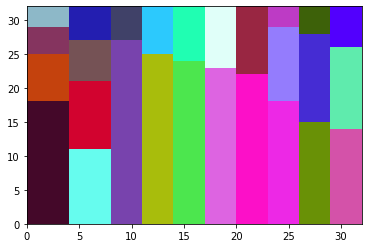


Paper dimensions: 33x33
Presents dimensions: [[7, 33], [3, 33], [3, 30], [3, 24], [4, 17], [4, 14], [3, 17], [4, 12], [3, 15], [3, 14], [4, 10], [3, 13], [3, 10], [3, 9], [3, 8], [4, 6], [3, 7], [3, 6], [4, 4], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=2204
mzn-stat: flatIntVars=902
mzn-stat: flatBoolConstraints=1127
mzn-stat: flatIntConstraints=2936
mzn-stat: evaluatedReifiedConstraints=118
mzn-stat: evaluatedHalfReifiedConstraints=2659
mzn-stat: eliminatedImplications=672
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.291487
mzn-stat-end
mzn-stat: initTime=0.072
mzn-stat: solveTime=0.038
mzn-stat: solutions=1
mzn-stat: variables=3117
mzn-stat: propagators=3811
mzn-stat: propagations=84887
mzn-stat: nodes=1544
mzn-stat: failures=766
mzn-stat: restarts=0
mzn-stat: peakDepth=67
mzn-stat-end
Solution: [[0, 0], [15, 0], [18, 0], [21, 0], [7, 0], [11, 0], [24, 0], 

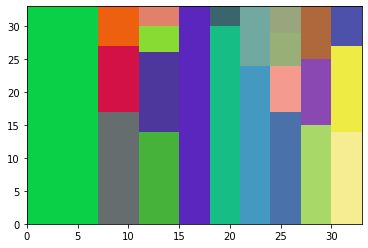


Paper dimensions: 34x34
Presents dimensions: [[12, 34], [3, 34], [3, 25], [3, 22], [3, 21], [4, 14], [4, 11], [3, 14], [3, 13], [3, 12], [3, 11], [3, 10], [3, 9], [3, 8], [3, 7], [4, 5], [3, 6], [4, 4], [3, 5], [3, 4], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1989
mzn-stat: flatIntVars=908
mzn-stat: flatBoolConstraints=1106
mzn-stat: flatIntConstraints=2738
mzn-stat: evaluatedReifiedConstraints=106
mzn-stat: evaluatedHalfReifiedConstraints=2512
mzn-stat: eliminatedImplications=720
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.304449
mzn-stat-end
mzn-stat: initTime=0.076
mzn-stat: solveTime=0.014
mzn-stat: solutions=1
mzn-stat: variables=2940
mzn-stat: propagators=3481
mzn-stat: propagations=38514
mzn-stat: nodes=715
mzn-stat: failures=353
mzn-stat: restarts=0
mzn-stat: peakDepth=26
mzn-stat-end
Solution: [[0, 0], [16, 0], [19, 0], [22, 0], [25, 0], [12, 0], [12, 14], [28, 0], [31, 0

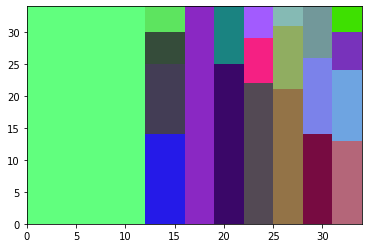


Paper dimensions: 35x35
Presents dimensions: [[14, 35], [4, 23], [4, 20], [4, 17], [3, 22], [3, 19], [4, 12], [3, 12], [4, 8], [3, 10], [4, 7], [3, 9], [3, 8], [4, 6], [3, 7], [4, 5], [3, 6], [4, 4], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1550
mzn-stat: flatIntVars=521
mzn-stat: flatBoolConstraints=657
mzn-stat: flatIntConstraints=1942
mzn-stat: evaluatedReifiedConstraints=78
mzn-stat: evaluatedHalfReifiedConstraints=1709
mzn-stat: eliminatedImplications=300
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.235655
mzn-stat-end
mzn-stat: initTime=0.051
mzn-stat: solveTime=0.056
mzn-stat: solutions=1
mzn-stat: variables=2079
mzn-stat: propagators=2430
mzn-stat: propagations=110965
mzn-stat: nodes=2579
mzn-stat: failures=1283
mzn-stat: restarts=0
mzn-stat: peakDepth=61
mzn-stat-end
Solution: [[0, 0], [14, 0], [18, 0], [22, 0], [26, 0], [29, 0], [22, 17], [32, 0], 

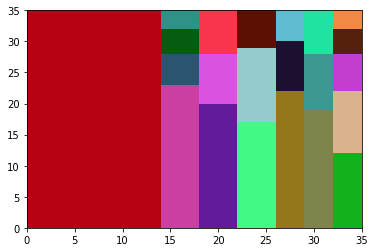


Paper dimensions: 36x36
Presents dimensions: [[12, 36], [3, 36], [4, 22], [5, 15], [3, 24], [5, 14], [3, 16], [3, 15], [4, 11], [3, 14], [3, 12], [3, 11], [3, 10], [3, 9], [3, 8], [3, 7], [5, 4], [3, 6], [3, 5], [5, 3], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1785
mzn-stat: flatIntVars=717
mzn-stat: flatBoolConstraints=895
mzn-stat: flatIntConstraints=2355
mzn-stat: evaluatedReifiedConstraints=85
mzn-stat: evaluatedHalfReifiedConstraints=2154
mzn-stat: eliminatedImplications=525
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.279879
mzn-stat-end
mzn-stat: initTime=0.06
mzn-stat: solveTime=0.029
mzn-stat: solutions=1
mzn-stat: variables=2569
mzn-stat: propagators=2782
mzn-stat: propagations=72569
mzn-stat: nodes=1837
mzn-stat: failures=913
mzn-stat: restarts=0
mzn-stat: peakDepth=51
mzn-stat-end
Solution: [[0, 0], [21, 0], [17, 0], [12, 0], [24, 0], [12, 15], [27, 0], 

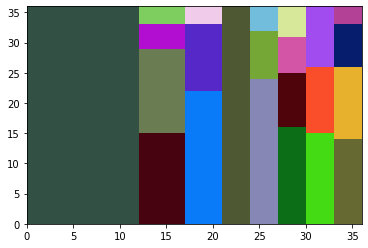


Paper dimensions: 37x37
Presents dimensions: [[12, 37], [4, 24], [4, 22], [5, 14], [3, 21], [3, 18], [3, 17], [5, 10], [3, 14], [4, 10], [3, 13], [3, 12], [3, 11], [5, 6], [3, 9], [3, 8], [4, 6], [3, 7], [4, 5], [5, 4], [3, 6], [4, 4], [3, 5], [5, 3], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=2111
mzn-stat: flatIntVars=652
mzn-stat: flatBoolConstraints=882
mzn-stat: flatIntConstraints=2607
mzn-stat: evaluatedReifiedConstraints=85
mzn-stat: evaluatedHalfReifiedConstraints=2362
mzn-stat: eliminatedImplications=406
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.280929
mzn-stat-end
mzn-stat: initTime=0.069
mzn-stat: solveTime=0.056
mzn-stat: solutions=1
mzn-stat: variables=2811
mzn-stat: propagators=3014
mzn-stat: propagations=121310
mzn-stat: nodes=2065
mzn-stat: failures=1027
mzn-stat: restarts=0
mzn-stat: peakDepth=54
mzn-stat-end
Solution: [[0, 0], [17, 0], [21, 0], [1

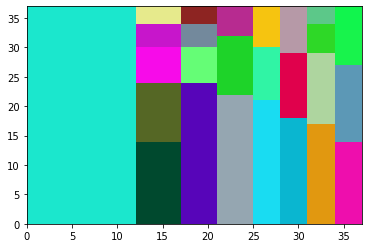


Paper dimensions: 38x38
Presents dimensions: [[24, 38], [4, 16], [4, 15], [4, 12], [4, 11], [3, 13], [3, 11], [4, 8], [3, 10], [3, 9], [3, 8], [4, 6], [3, 7], [4, 5], [3, 6], [3, 5], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1022
mzn-stat: flatIntVars=335
mzn-stat: flatBoolConstraints=389
mzn-stat: flatIntConstraints=1266
mzn-stat: evaluatedReifiedConstraints=50
mzn-stat: evaluatedHalfReifiedConstraints=1082
mzn-stat: eliminatedImplications=146
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.190838
mzn-stat-end
mzn-stat: initTime=0.036
mzn-stat: solveTime=0.034
mzn-stat: solutions=1
mzn-stat: variables=1365
mzn-stat: propagators=1527
mzn-stat: propagations=96893
mzn-stat: nodes=2286
mzn-stat: failures=1137
mzn-stat: restarts=0
mzn-stat: peakDepth=69
mzn-stat-end
Solution: [[0, 0], [24, 0], [28, 0], [28, 15], [24, 16], [32, 0], [35, 0], [24, 27], [35, 11], [32, 13], [35,

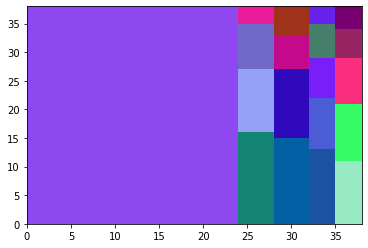


Paper dimensions: 39x39
Presents dimensions: [[15, 39], [5, 18], [5, 13], [4, 16], [4, 15], [5, 11], [5, 10], [4, 12], [3, 15], [5, 8], [4, 9], [3, 11], [4, 8], [3, 10], [5, 6], [3, 9], [5, 5], [3, 8], [4, 6], [3, 7], [4, 5], [5, 4], [3, 6], [4, 4], [3, 5], [5, 3], [3, 4], [4, 3], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=2157
mzn-stat: flatIntVars=525
mzn-stat: flatBoolConstraints=752
mzn-stat: flatIntConstraints=2540
mzn-stat: evaluatedReifiedConstraints=78
mzn-stat: evaluatedHalfReifiedConstraints=2257
mzn-stat: eliminatedImplications=234
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.245799
mzn-stat-end
mzn-stat: initTime=0.065
mzn-stat: solveTime=0.182
mzn-stat: solutions=1
mzn-stat: variables=2690
mzn-stat: propagators=3094
mzn-stat: propagations=358097
mzn-stat: nodes=5709
mzn-stat: failures=2846
mzn-stat: restarts=0
mzn-stat: peakDepth=118
mzn-stat-end
Solution: [[0, 0], [15, 

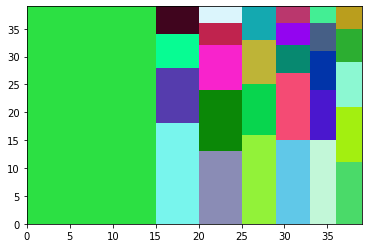


Paper dimensions: 40x40
Presents dimensions: [[22, 40], [3, 40], [4, 22], [5, 13], [5, 12], [4, 14], [3, 16], [5, 8], [3, 12], [3, 10], [3, 9], [3, 8], [3, 7], [5, 4], [3, 6], [4, 4], [3, 5], [5, 3], [3, 4], [3, 3]]
Column stacking: true
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=931
mzn-stat: flatIntVars=320
mzn-stat: flatBoolConstraints=382
mzn-stat: flatIntConstraints=1154
mzn-stat: evaluatedReifiedConstraints=41
mzn-stat: evaluatedHalfReifiedConstraints=1024
mzn-stat: eliminatedImplications=165
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.190393
mzn-stat-end
mzn-stat: initTime=0.033
mzn-stat: solveTime=0.007
mzn-stat: solutions=1
mzn-stat: variables=1326
mzn-stat: propagators=1182
mzn-stat: propagations=25091
mzn-stat: nodes=596
mzn-stat: failures=294
mzn-stat: restarts=0
mzn-stat: peakDepth=37
mzn-stat-end
Solution: [[0, 0], [31, 0], [27, 0], [22, 0], [22, 13], [27, 22], [34, 0], [22, 25], [37, 0], [37, 12],

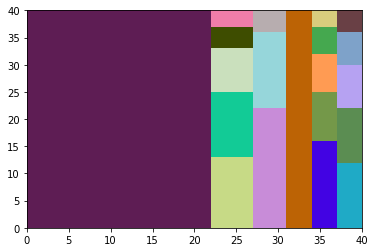


Instance size / Running time plot:


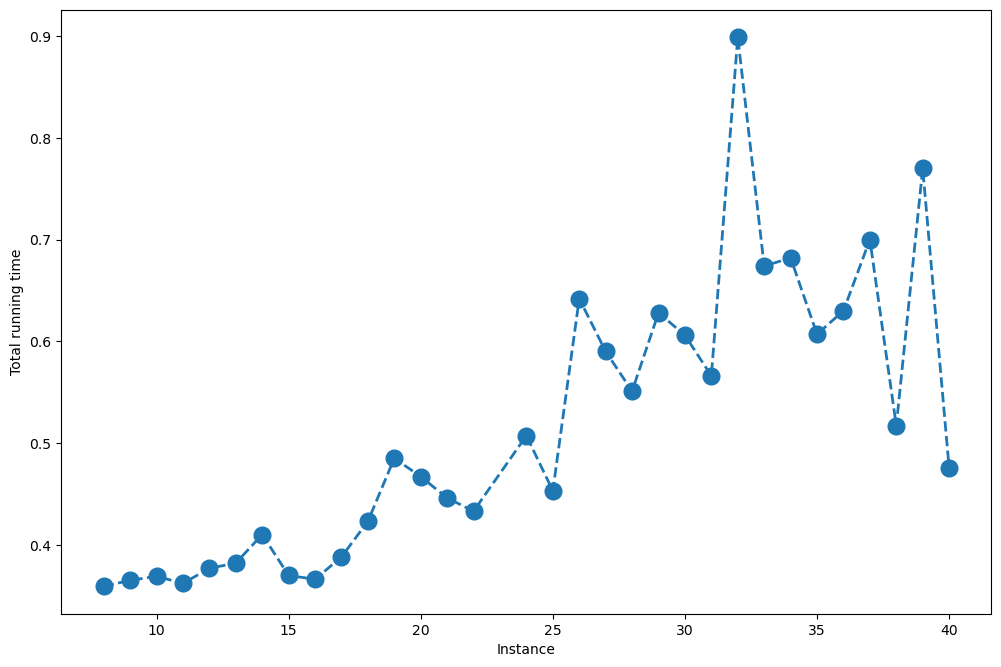

In [86]:
times = []
instances = []
if instance is not None:
    min_instance, max_instance = instance, instance
for i in range(min_instance, max_instance + 1):
    current_instance = f"{i}x{i}"
    path = f"instances/{current_instance}.txt"
    w_paper, h_paper, n, presents = read_input(path)
    unordered_presents = list(presents)
    presents, sorted_indices = order_presents(presents, method='area', reverse=True)
    bl_corners = []
    print(f"Paper dimensions: {i}x{i}")
    print(f"Presents dimensions: {presents}")
    start_time = time()
    solutions = %minizinc -s pwp-v6
    end_time = time()
    if solutions:
        show_solutions(w_paper, h_paper, n, presents, solutions, model='cp')
        instances.append(i)
        times.append(end_time - start_time)
    print()

if len(instances) > 1:
    print("Instance size / Running time plot:")
    show_running_times(instances, times)

### First model 

In this first CP model we tried to put a single constraint, regarding rectangles overlapment. The constraint is implemented as a list of disjunctive comparisons and, because of that, running times of the whole model tend to be very high, starting from the smaller and easier instances.

In [88]:
%%mzn_model pwp-v1
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of int: presents;

% Variables
array[1..n, 1..2] of var 0..max(w_paper, h_paper) - 1: bl_corners;

% Constraints
% Presents cannot overlap
constraint forall(i, j in 1..n where j > i) (
    max(bl_corners[i, 1], bl_corners[j, 1]) >= min(bl_corners[i, 1] + presents[i, 1], bl_corners[j, 1] + presents[j, 1]) \/
    max(bl_corners[i, 2], bl_corners[j, 2]) >= min(bl_corners[i, 2] + presents[i, 2], bl_corners[j, 2] + presents[j, 2])
);

% Reduce presents domains
constraint forall(i in 1..n) (bl_corners[i, 1] <= w_paper - presents[i, 1]);
constraint forall(i in 1..n) (bl_corners[i, 2] <= h_paper - presents[i, 2]);

% Search
solve satisfy;

### Second model

In this second CP model we refactored the non-overlapping constraint by removing the disjuctive part and instead forcing all overlapping areas to be zero. Moreover, we introduced a new list of variables (`bl_corners_values`) which can be viewed as a linearization of the 2D coordinates associated with rectangles bottom left corners, since we wanted to add redundant constraints, to deal with values distribution inside the 2D space. In particular, we posed an `alldifferent` constraint over `bl_corners_values` and we forced a single rectangle to be located at `(0, 0)`.

In [93]:
%%mzn_model pwp-v2
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of int: presents;

% Constants
int: max_dim = max(w_paper, h_paper);
int: min_present_dim = min([min(presents[i, 1], presents[i, 2]) | i in 1..n]);

% Variables
array[1..n, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[1..n] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;

% Functions
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);
function var int: x_overlap(int: i, int: j) = 
    max(0, min(bl_corners[i, 1] + presents[i, 1], bl_corners[j, 1] + presents[j, 1]) - max(bl_corners[i, 1], bl_corners[j, 1]));
function var int: y_overlap(int: i, int: j) = 
    max(0, min(bl_corners[i, 2] + presents[i, 2], bl_corners[j, 2] + presents[j, 2]) - max(bl_corners[i, 2], bl_corners[j, 2]));
function var int: overlap_area(int: i, int: j) = x_overlap(i, j) * y_overlap(i, j);

% Channeling constraints
predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners[i, 1], bl_corners[i, 2]);
constraint forall(i in ns) (values_channeling(i));

% Constraints
% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Presents cannot overlap
constraint forall(i, j in 1..n where j > i) (overlap_area(i, j) == 0);

% Reduce presents domains
constraint forall(i in 1..n) (bl_corners[i, 1] <= w_paper - presents[i, 1]);
constraint forall(i in 1..n) (bl_corners[i, 2] <= h_paper - presents[i, 2]);

% Search
solve satisfy;

### Third model

In this third model we tried to further reduce our variable's domains, by introducing a new list of variables (`tr_corners`), representing top right corners of each rectangle. The main achievement of this model is the introduction of the global constraint `diffn_k` to handle non-overlapment and of the global constrainst `cumulative` to maximally stack rectangles on each axis. Moreover, we used top right corners to force rectangles to stay inside the outer container.

In [97]:
%%mzn_model pwp-v3
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[1..n, 1..2] of 1..max_dim: presents;

% Constants
int: max_dim = max(w_paper, h_paper);
int: min_present_dim = min([min(presents[i, 1], presents[i, 2]) | i in 1..n]);
array[1..n] of 1..max_dim: presents_xs = [presents[i, 1] | i in 1..n];
array[1..n] of 1..max_dim: presents_ys = [presents[i, 2] | i in 1..n];

% Variables
array[1..n, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[1..n, 1..2] of var 1..max_dim: tr_corners;
array[1..n] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;
array[1..n] of var 0..w_paper - min_present_dim: bl_corners_xs;
array[1..n] of var 0..h_paper - min_present_dim: bl_corners_ys;

% Functions
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

% Constraints
% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Presents cannot overlap
constraint diffn_k(bl_corners, presents);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= presents_xs[i] /\ 
    tr_corners[i, 2] >= presents_ys[i]
);

% Search
solve satisfy;

### Fourth model

In this fourth model we tried to add different constraints, to possibly enhance running times:
* Redundant constraints:
    * Try and stack two presents having the same width s.t. their heights would sum to the total height 
    * Sum of all the areas of all the placed presents equal to total area
* Symmetry breaking constraints:
    * Presents in the same column ordered by width (which resulted in an overall slowdown)
    * Biggest rectangle contained in the lower-left quadrant (which didn't lead to any major improvement)

In [127]:
%%mzn_model pwp-v4
include "globals.mzn";

%Input values
int: w_paper;
int: h_paper;
int: n;
array[ns, 1..2] of int: presents;

% Constants
int: max_dim = max(w_paper, h_paper);
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
int: max_present_ind = arg_max(areas);
set of int: ns = 1..n;
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];

% Variables
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;

% Functions
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

% Constraints
% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= presents_xs[i] /\ 
    tr_corners[i, 2] >= presents_ys[i]
);

% Two presents sum to total height or width
constraint forall(i, j in ns where j > i) (
    presents_xs[i] == presents_xs[j] /\ presents_ys[i] + presents_ys[j] == h_paper -> 
    bl_corners_ys[j] = presents_ys[i] /\ bl_corners_ys[i] = 0
);
constraint forall(i, j in ns where j > i) (
    presents_ys[i] == presents_ys[j] /\ presents_xs[i] + presents_xs[j] == w_paper -> 
    bl_corners_xs[j] = presents_xs[i] /\ bl_corners_xs[i] = 0
);

% Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) <= total_paper_area;
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) == total_presents_area;

% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Presents cannot overlap
constraint diffn_k(bl_corners, presents);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

% Symmetry breaking constraints
% Biggest rectangle contained in the lower-left quadrant
constraint 
    bl_corners_xs[max_present_ind] <= (w_paper - presents_xs[max_present_ind]) / 2 /\ 
    bl_corners_ys[max_present_ind] <= (h_paper - presents_ys[max_present_ind]) / 2;

/*
% Presents in the same column ordered by width
constraint forall(i, j in ns where j > i) (
    bl_corners_xs[i] == bl_corners_xs[j] /\ presents_xs[i] <= presents_xs[j] -> 
    bl_corners_ys[i] > bl_corners_ys[j]
);
*/

% Search
solve satisfy;

### Fifth model

In this fifth model we are generalizing the idea of stacking two rectangles of the same width with heights summing to the total height, to:
* Partition rectangles in groups representing different widths (`presents_group_xs`)
* Check whether all groups form one or more columns (predicate `is_col_stacking_feasible`)
    * If possible, assign each rectangle to a specific column and constrain the other rectangles to follow (predicate `stack_cols`)
    * If not possible, operate in previous models

The predicate `stack_cols` works as follows:
* For each rectangle group
    * Find a feasible `bin_packing` over a pre-computed number of columns
    * For each rectangle in the same column (same bin), add a constraint to fix its bottom left corner

We also tried to combine our ad-hoc column stacking procedure with the approaches described below (_intervals_ and _anchor points_), without any luck.

In [98]:
%%mzn_model pwp-v5
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[ns, 1..2] of int: presents;

% Constants
bool: col_stacking_feasible = is_col_stacking_feasible();
int: max_dim = max(w_paper, h_paper);
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
int: max_present_ind = arg_max(areas);
set of int: ns = 1..n;
set of int: presents_xs_values = distinct_values(presents_xs);
array[int] of int: presents_xs_ordered_values = sort_by(presents_xs_values, [-i | i in presents_xs_values]);
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];
array[1..card(presents_xs_values)] of set of ns: presents_group_xs = [group_presents(i, 1) | i in presents_xs_ordered_values];
array[1..card(presents_xs_values)] of int: group_columns = 
    [sum([presents_ys[j] | j in presents_group_xs[i]]) div h_paper | i in 1..card(presents_xs_values)];
array[1..card(presents_xs_values)] of int: group_widths = 
    [sum([presents_xs[j] | j in presents_group_xs[i]]) div card(presents_group_xs[i]) | i in 1..card(presents_xs_values)];

% Variables
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;

% Functions
function bool: is_col_stacking_feasible() = 
    sum([sum([presents_ys[j] | j in presents_group_xs[i]]) >= h_paper | i in 1..card(presents_xs_values)]) == card(presents_xs_values);
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function set of int: distinct_values(array[int] of int: x) = {j | j in lb_array(x)..ub_array(x), i in index_set(x) where x[i] = j };
function set of ns: group_presents(int: size, int: axis) = {i | i in ns where presents[i, axis] == size};
function int: get_starting_point(int: i) = sum([group_columns[j] * group_widths[j] | j in 1..i - 1]);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

% Constraints
% Stack presents with the same width on the same column
predicate stack_cols(int: i, int: starting_point) = let { 
    int: n_presents = card(presents_group_xs[i]);
    array[1..n_presents] of ns: indexes = [j | j in presents_group_xs[i]];
    array[1..n_presents] of 1..h_paper: weights = [presents_ys[j] | j in indexes];
    int: columns = group_columns[i];
    array[1..n_presents] of var 1..columns: bins
    } in 
        bin_packing(h_paper, bins, weights) /\
        forall(h in 1..n_presents, l in 1..columns where bins[h] == l) (
            bl_corners_xs[indexes[h]] == starting_point + (group_widths[i] * (l - 1)) /\
            bl_corners_ys[indexes[h]] == sum([weights[j] | j in 1..h - 1 where bins[j] == l]) 
        );
constraint
    trace("Column stacking: " ++ show(col_stacking_feasible) ++ "\n", col_stacking_feasible) -> 
    forall(i in 1..card(presents_xs_values)) (stack_cols(i, get_starting_point(i)));

% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= presents_xs[i] /\ 
    tr_corners[i, 2] >= presents_ys[i]
);

% Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) <= total_paper_area;
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) == total_presents_area;

% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Presents cannot overlap
constraint diffn_k(bl_corners, presents);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint not(col_stacking_feasible) -> cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

% Symmetry breaking constraints
% Biggest rectangle contained in the lower-left quadrant
constraint not(col_stacking_feasible) ->
    bl_corners_xs[max_present_ind] <= (w_paper - presents_xs[max_present_ind]) / 2 /\ 
    bl_corners_ys[max_present_ind] <= (h_paper - presents_ys[max_present_ind]) / 2;

% Search
solve satisfy;

#### Intervals approach

The following section contains a block of code that was tested in the above model, but didn't provide significant improvements. It represents an idea taken from the paper _New Improvements in Optimal Rectangle Packing (Eric Huang, Richard E. Korf)_, where domains associated with the x-coordinate of bottom left corners are reduced on the basis of a variable-sized interval:
> \[...\] a rectangle is assigned an interval of x-coordinates. Interval sizes are hand-picked for each rectangle prior to search, and they induce a smaller rectangle representing the common intersecting area of placing the rectangle in any location in the interval. \[...\] we assign all x-coordinates prior to any y-coordinates, and use interval variables for the x-coordinates. We set a rectangle’s interval size to 0.35 times its width, which gave us the best performance. Finally, we do not use interval variables for the y-coordinates.`

In [ ]:
% Constants
array[ns] of int: x_intervals_sizes = [ceil(presents_xs[i] * 0.35) | i in ns];

% Variables
array[ns, 1..2] of var 0..w_paper: x_intervals;

% Channeling constraints
predicate x_intervals_channeling(int: i) = 
    x_intervals[i, 2] == x_intervals[i, 1] + x_intervals_sizes[i] /\
    bl_corners_xs[i] >= x_intervals[i, 1] /\
    bl_corners_xs[i] <= x_intervals[i, 2];
constraint forall(i in ns) (x_intervals_channeling(i));

% Constraints
% Reduce corners domains based on x intervals
constraint forall(i, j in ns where j != i) (
    not(
        bl_corners_xs[j] < x_intervals[i, 2] + presents_xs[i] - x_intervals_sizes[i] /\ 
        bl_corners_xs[j] > x_intervals[i, 2] /\
        bl_corners_ys[j] >= bl_corners_ys[i] /\
        bl_corners_ys[j] < bl_corners_ys[i] + presents_ys[i]     
    )
);

% Search
solve :: seq_search([
    int_search(x_intervals, smallest, indomain_min),
    int_search(bl_corners_xs, smallest, indomain_min),
    int_search(bl_corners_ys, smallest, indomain_min)
]) satisfy;

#### Anchor points approach

The following section contains a block of code that was tested in the above model, but didn't provide significant improvements. It represents a reduction on each present's domain, s.t. bottom left corners reside on corners of other rectangles or on the wrapping paper borders.

The main problem of this implementation was our inability of correctly expressing the constraint in an efficient way.

In [ ]:
% Variables
array[ns, 1..4] of var 0..coord_to_value(w_paper, h_paper): corners_values;

% Channeling constraints
predicate corners_values_channeling(int: i) = 
    corners_values[i, 1] == bl_corners_values[i] /\ 
    corners_values[i, 2] == coord_to_value(bl_corners_xs[i] + presents_xs[i], bl_corners_ys[i]) /\
    corners_values[i, 3] == coord_to_value(tr_corners[i, 1], tr_corners[i, 2]) /\
    corners_values[i, 4] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i] + presents_ys[i]);
constraint forall(i in ns) (corners_values_channeling(i));

% Constraints
% Corners anchor points
predicate anchor_points() = let {
        array[1..n * 4] of var int: lin_corners_values = array1d(1..n * 4, corners_values)
    } in
    nvalue(lin_corners_values) <= 2 * n + 2 /\ 
    count_eq(lin_corners_values, coord_to_value(0, 0), 1) /\
    count_eq(lin_corners_values, coord_to_value(0, w_paper), 1) /\
    count_eq(lin_corners_values, coord_to_value(h_paper, 0), 1) /\
    count_eq(lin_corners_values, coord_to_value(w_paper, h_paper), 1);
constraint anchor_points();

### Sixth model

In this sixth final model we are keeping the column stacking mechanism and introducing a new variables ordering (by decreasing rectangles areas) for symmetry breaking constraints and for a new search strategy. 

These adaptations were taken from _Implementation and Evaluation of a Sweep-Based Propagator for Diffn in Gecode (Mikael Östlund)_.

Moreover, we tried to implement another anchor points approach, which didn't work out as expected.

In [85]:
%%mzn_model pwp-v6
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[ns, 1..2] of int: presents;

% Constants
bool: col_stacking_feasible = is_col_stacking_feasible();
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: max_dim = max(w_paper, h_paper);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
set of int: ns = 1..n;
set of int: presents_xs_values = distinct_values(presents_xs);
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];
array[ns] of ns: order = sort_by(ns, [-areas[i] | i in ns]);
array[1..card(presents_xs_values)] of int: presents_xs_ordered_values = sort_by(presents_xs_values, [-i | i in presents_xs_values]);
array[1..card(presents_xs_values)] of set of ns: presents_group_xs = [group_presents(i, 1) | i in presents_xs_ordered_values];
array[1..card(presents_xs_values)] of int: group_columns = 
    [sum([presents_ys[j] | j in presents_group_xs[i]]) div h_paper | i in 1..card(presents_xs_values)];
array[1..card(presents_xs_values)] of int: group_widths = 
    [sum([presents_xs[j] | j in presents_group_xs[i]]) div card(presents_group_xs[i]) | i in 1..card(presents_xs_values)];

% Variables
array[ns, 1..2] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..w_paper - min_present_width: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_height: bl_corners_ys;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;

% Functions
function bool: is_col_stacking_feasible() = 
    sum([sum([presents_ys[j] | j in presents_group_xs[i]]) >= h_paper | i in 1..card(presents_xs_values)]) == card(presents_xs_values);
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function set of int: distinct_values(array[int] of int: x) = {j | j in lb_array(x)..ub_array(x), i in index_set(x) where x[i] = j };
function set of ns: group_presents(int: size, int: axis) = {i | i in ns where presents[i, axis] == size};
function int: get_starting_point(int: i) = sum([group_columns[j] * group_widths[j] | j in 1..i - 1]);
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

% Constraints
% Stack presents with the same width on the same column
predicate stack_cols(int: i, int: starting_point) = let { 
    int: n_presents = card(presents_group_xs[i]);
    array[1..n_presents] of ns: indexes = [j | j in presents_group_xs[i]];
    array[1..n_presents] of 1..h_paper: weights = [presents_ys[j] | j in indexes];
    array[1..n_presents] of 1..n_presents: positions = sort_by([j | j in 1..n_presents], [-weights[j] | j in 1..n_presents]);
    array[1..n_presents] of ns: ord_indexes = [indexes[j] | j in positions];
    array[1..n_presents] of 1..h_paper: ord_weights = [weights[j] | j in positions];
    int: columns = group_columns[i];
    array[1..n_presents] of var 1..columns: bins
    } in 
        bin_packing(h_paper, bins, ord_weights) /\
        forall(h in 1..n_presents, l in 1..columns where bins[h] == l) (
            bl_corners_xs[ord_indexes[h]] == starting_point + (group_widths[i] * (l - 1)) /\
            bl_corners_ys[ord_indexes[h]] == sum([ord_weights[j] | j in 1..h - 1 where bins[j] == l]) 
        );
constraint
    trace("Column stacking: " ++ show(col_stacking_feasible) ++ "\n", col_stacking_feasible) -> 
    forall(i in 1..card(presents_xs_values)) (stack_cols(i, get_starting_point(i)));

% Presents cannot overlap
constraint diffn_k(bl_corners, presents);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper);
constraint not(col_stacking_feasible) -> cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper);

% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= presents_xs[i] /\ 
    tr_corners[i, 2] >= presents_ys[i]
);

% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) <= total_paper_area;
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) == total_presents_area;

% Non-optimal constraints
% Anchor points
/*
constraint forall(i in ns)(
    member([0] ++ [bl_corners_xs[j] + presents_xs[j] | j in ns where j != i], bl_corners_xs[i]) /\
    member([0] ++ [bl_corners_ys[j] + presents_ys[j] | j in ns where j != i], bl_corners_ys[i])
);
*/

% Symmetry breaking constraints
% The biggest rectangle should be placed below the second biggest
constraint let {
    int: i = order[1], int: j = order[2]
} in not(col_stacking_feasible) ->
    lex_less([bl_corners_ys[i], bl_corners_xs[i]], [bl_corners_ys[j], bl_corners_xs[j]]);

% Search
solve::
    if not(col_stacking_feasible) then
        seq_search([
            int_search([bl_corners_ys[i] | i in order], input_order, indomain_min, complete),
            int_search([bl_corners_xs[i] | i in order], input_order, indomain_min, complete)
        ])
    else int_search(bl_corners_values, dom_w_deg, indomain_min, complete)
    endif
satisfy;

### Seventh model (with rotation and same dimensions handling)

This model is dedicated to the implementation of the optional parts of the project, namely rotation and same dimensions handling.
About rotation, we removed the column stacking approach since presents dimensions are now considered as variables, and we introduced the global constraint `geost_bb` which can be used to find appropriate positions and rotations of the given rectangles without overlaps, by constraining them to be contained in a given bounding box. This approach obviously turned out to be much slower w.r.t. our sixth model. To get better results, we could try to find the minimum number of rotations needed to make column stacking feasible and proceed like before.
About rectangles with same dimensions, we simply included a symmetry breaking constraint accounting for pairwise positioning of equally-sized rectangles.

In [69]:
%%mzn_model pwp-v7
include "globals.mzn";

% Input values
int: w_paper;
int: h_paper;
int: n;
array[ns, 1..2] of int: presents;

% Constants
int: k = 2;
int: total_paper_area = w_paper * h_paper;
int: total_presents_area = sum(areas);
int: max_dim = max(w_paper, h_paper);
int: min_present_width = min(presents_xs);
int: min_present_height = min(presents_ys);
int: max_present_width = max(presents_xs);
int: max_present_height = max(presents_ys);
int: min_present_dim = min([min_present_width, min_present_height]);
int: max_present_dim = max([max_present_width, max_present_height]);
set of int: dim = 1..k;
set of int: ns = 1..n;
set of int: ns_rot = 1..2 * n;
array[dim] of int: l = [0, 0];
array[dim] of int: u = [w_paper, h_paper];
array[ns] of int: presents_xs = [presents[i, 1] | i in ns];
array[ns] of int: presents_ys = [presents[i, 2] | i in ns];
array[ns] of int: areas = [presents_xs[i] * presents_ys[i] | i in ns];
array[ns] of ns: order = sort_by(ns, [-areas[i] | i in ns]);
array[ns_rot, dim] of int: rect_size = array2d(ns_rot, dim, [get_rot(i, j, k)| i in ns, j, k in 0..1]);
array[ns_rot, dim] of int: rect_offset = array2d(ns_rot, dim, [0 | i in 1..4 * n]);
array[ns_rot] of set of ns_rot: shape = [{i}| i in ns_rot];
array[ns] of set of ns_rot: valid_shapes = [{i, i + 1}| i in ns_rot where i mod 2 != 0];

% Variables
array[ns, dim] of var 0..max_dim - min_present_dim: bl_corners;
array[ns, 1..2] of var min_present_dim..max_dim: tr_corners;
array[ns] of var 0..w_paper - min_present_dim: bl_corners_xs;
array[ns] of var 0..h_paper - min_present_dim: bl_corners_ys;
array[ns] of var 0..coord_to_value(w_paper, h_paper): bl_corners_values;
array[ns] of var min_present_dim..max_present_dim: actual_presents_xs = [actual_dim(i, 1) | i in ns];
array[ns] of var min_present_dim..max_present_dim: actual_presents_ys = [actual_dim(i, 2) | i in ns];
array[ns] of var ns_rot: kind;

% Functions
function int: coord_to_value(int: x, int: y) = x + (y * max_dim);
function int: other_axis(int: axis) = if axis == 1 then 2 elseif axis == 2 then 1 else -1 endif;
function int: get_dim(int: ind, int: axis) = if axis == 0 then presents_xs[ind] elseif axis == 1 then presents_ys[ind] else -1 endif;
function int: get_rot(int: ind, int: axis, int: rot) = if rot == 0 then get_dim(ind, axis) elseif rot == 1 then get_dim(ind, 1 - axis) else -1 endif;
function var int: coord_to_value(var int: x, var int: y) = x + (y * max_dim);
function var int: actual_dim(int: ind, int: axis) = if kind[ind] mod 2 == 0 then presents[ind, other_axis(axis)] else presents[ind, axis] endif;

% Channeling constraints
predicate bl_corners_channeling(int: i) = 
    bl_corners_xs[i] == bl_corners[i, 1] /\ 
    bl_corners_ys[i] == bl_corners[i, 2];
constraint forall(i in ns) (bl_corners_channeling(i));

predicate tr_corners_channeling(int: i) = 
    tr_corners[i, 1] == bl_corners_xs[i] + actual_presents_xs[i] /\ 
    tr_corners[i, 2] == bl_corners_ys[i] + actual_presents_ys[i];
constraint forall(i in ns) (tr_corners_channeling(i));

predicate values_channeling(int: i) = 
    bl_corners_values[i] == coord_to_value(bl_corners_xs[i], bl_corners_ys[i]);
constraint forall(i in ns) (values_channeling(i));

% Constraints
% Presents cannot overlap
constraint diffn(bl_corners_xs, bl_corners_ys, actual_presents_xs, actual_presents_ys);

% Presents should be contained inside the wrapping paper and they should be maximally stacked
constraint cumulative(bl_corners_xs, actual_presents_xs, actual_presents_ys, h_paper);
constraint cumulative(bl_corners_ys, actual_presents_ys, actual_presents_xs, w_paper);

% Reduce presents domains
constraint forall(i in ns) (
    bl_corners_xs[i] <= w_paper - actual_presents_xs[i] /\ 
    bl_corners_ys[i] <= h_paper - actual_presents_ys[i]
);
constraint forall(i in ns) (
    tr_corners[i, 1] >= actual_presents_xs[i] /\ 
    tr_corners[i, 2] >= actual_presents_ys[i]
);

% All the presents have different bottom left corners
constraint alldifferent(bl_corners_values);

% One present is always placed at the origin
constraint count_eq(bl_corners_values, 0, 1);

% Sum of all the areas of all the placed presents equal to total area
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) <= total_paper_area;
constraint sum(i in ns) (
    (tr_corners[i, 1] - bl_corners[i, 1]) * (tr_corners[i, 2] - bl_corners[i, 2])
) == total_presents_area;

% Rectangles must have valid shapes
constraint forall (obj in ns) (kind[obj] in valid_shapes[obj]);

% Non-overlap, bounding box, rotation handling 
constraint geost_bb(k, rect_size, rect_offset, shape, bl_corners, kind, l, u);

% Symmetry breaking constraints
% The biggest rectangle should be placed below the second biggest
constraint let {
    int: i = order[1], int: j = order[2]
} in lex_less([bl_corners_ys[i], bl_corners_xs[i]], [bl_corners_ys[j], bl_corners_xs[j]]);

% Rectangles with same dimensions handling
constraint forall(i in ns)(
    let {
        array[int] of int: same_dim_ind = [j | j in ns where presents_xs[j] = presents_xs[i] /\ presents_ys[j] = presents_ys[i]]
    } in 
        if length(same_dim_ind) > 1 /\ min(same_dim_ind) = i then
            forall(j in index_set(same_dim_ind) where j > 1) (
                lex_less(
                    [bl_corners_ys[same_dim_ind[j - 1]], bl_corners_xs[same_dim_ind[j - 1]]], 
                    [bl_corners_ys[same_dim_ind[j]], bl_corners_xs[same_dim_ind[j]]]
                )
            )
        else true 
        endif
);

% Search
solve:: seq_search([
    int_search([bl_corners_ys[i] | i in order], input_order, indomain_min, complete),
    int_search([bl_corners_xs[i] | i in order], input_order, indomain_min, complete)
]) satisfy;

## SMT

### Functions

In [187]:
def member(x, l):
    '''
    Return a contraint computing membership testing
    '''
    return Or([x == l[i] for i in range(len(l))])

def z3_max_list(l):
    '''
    Return a constraint computing the maximum over a list of variables
    '''
    c = []
    max_value = Int(rand_str())
    c.append(member(max_value, l))
    for i in range(len(l)):
        c.append(max_value >= l[i])
    return max_value, c

def z3_max(x, y):
    '''
    Return a constraint computing the maximum of two variables
    '''
    return If(x > y, x, y)

def z3_min_list(l):
    '''
    Return a constraint computing the minimum over a list of variables
    '''
    c = []
    min_value = Int(rand_str())
    c.append(member(min_value, l))
    for i in range(len(l)):
        c.append(min_value <= l[i])
    return min_value, c

def z3_min(x, y):
    '''
    Return a constraint computing the minimum of two variables
    '''
    return If(x < y, x, y)

def z3_bool2int(v):
    '''
    Convert a boolean variable to an integer one
    '''
    return IntSort().cast(v)

def z3_diffn(x, y, dx, dy):
    '''
    Return a list of constraints computing non-overlapping checks
    '''
    c = []
    n = len(x)
    for i in range(n):
        for j in range(i + 1, n):
            c.append(
                And(Or([
                    x[i] + dx[i] <= x[j],
                    y[i] + dy[i] <= y[j],
                    x[j] + dx[j] <= x[i],
                    y[j] + dy[j] <= y[i]
                ]))
            )
    return c

def z3_cumulative(s, d, r, b, ls, us):
    '''
    Return a list of constraints computing cumulative checks.
    Here, resources `r`, durations `d` and bound `b` must be fixed
    '''
    c = []
    early = ls
    late = us + max(d)
    tasks = [i for i in range(len(s)) if r[i] > 0 and d[i] > 0]
    if late - early < 5000:
        for i in tasks:
            c1 = []
            for j in tasks:
                if j != i:
                    c1.append(z3_bool2int(And(s[j] <= s[i], s[i] < s[j] + d[j])) * r[j])
            c.append(b >= r[i] + Sum(c1))
    else:
        for t in range(early, late + 1):
            for i in tasks:
                c.append(
                    Sum([(If(s[i] <= t, 1, 0) * If(t < s[i] + d[i], 1, 0)) * r[i] for i in tasks]) <= b
                )
    return c

### Input

In [207]:
instance = 29
min_instance, max_instance = 8, 40

In [208]:
times = []
instances = []
if instance is not None:
    min_instance, max_instance = instance, instance
for i in range(min_instance, max_instance + 1):
    current_instance = f"{i}x{i}"
    instances.append(current_instance)
    path = f"instances/{current_instance}.txt"
    w_paper, h_paper, n, presents = read_input(path)
    print(f"Paper dimensions: {i}x{i}")
    print(f"Presents dimensions: {presents}")
    start_time = time()
    bl_corners, model = smt_v1(w_paper, h_paper, n, presents)
    model.check()
    assignment = model.model()
    solution = [[assignment[bl_corners[i][0]].as_long(), assignment[bl_corners[i][1]].as_long()] for i in range(n)]
    end_time = time()
    total_time = end_time - start_time
    times.append(total_time)
    print(model.statistics())
    print(f"Total running time: {round(total_time, 3)} seconds")
    if solution:
        show_solution(w_paper, h_paper, n, presents, solution)
        output(w_paper, h_paper, n, presents, solution, model='smt')
print("Instance size / Running time plot:")
show_running_times(instances, times)

Paper dimensions: 29x29
Presents dimensions: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]


Z3Exception: model is not available

### First model

In [192]:
def smt_v1(w_paper, h_paper, n, presents):
    presents_xs = [presents[i][0] for i in range(n)]
    presents_ys = [presents[i][1] for i in range(n)]
    bl_corners = [ [ Int("c_%s_%s" % (i, j)) for j in range(2) ] for i in range(n) ]
    bl_corners_xs = [bl_corners[i][0] for i in range(n)]
    bl_corners_ys = [bl_corners[i][1] for i in range(n)]
    domain = [
        And(
            0 <= bl_corners[i][0], bl_corners[i][0] <= w_paper - presents[i][0], 
            0 <= bl_corners[i][1], bl_corners[i][1] <= h_paper - presents[i][1]
        ) for i in range(n)
    ]
    no_overlap = z3_diffn(bl_corners_xs, bl_corners_ys, presents_xs, presents_ys)
    x_bound = z3_cumulative(bl_corners_xs, presents_xs, presents_ys, h_paper, 0, w_paper - 1);
    y_bound = z3_cumulative(bl_corners_ys, presents_ys, presents_xs, w_paper, 0, h_paper - 1);

    model = Solver()
    model.add(domain + no_overlap + x_bound + y_bound)
    return bl_corners, model